# Parte 4

El archivo excel 4000datosSimuladosEnergia.xlsx contiene datos de 4000 clientes ficticios de una empresa comercializadora de energía eléctrica y gas. Cada contrato tiene 10 atributos:

1. Antigüedad del contrato
2. Superficie del domicilio
3. Potencia eléctrica contratada
4. Consumo de electricidad en punta
5. Consumo de electricidad en llano
6. Consumo de electricidad en valle
7. Consumo de gas medio
8. Generación fotovoltaica
9. Bonificaciones consumo
10. Programa puntos


Se desea visualizar los 4000 contratos en un mapa, de forma que se pueda identificar visualmente si hay grupos de contratos con las mismas propiedades. Como ayuda, se proporciona una columna
adicional, llamada `11. Perfil de contrato`.

Esta columna es la solución del problema. Solo se empleará para colorear los puntos del mapa (es decir, si algún método produjese un mapa correcto, éste debería consistir en figuras aisladas de
diferente color).

Ninguno de los algoritmos de generación de mapas debería hacer uso de esta variable salvo para colorear el resultado final.

Lista de métodos:
1. PCA
2. LLE LTSA
3. MDS
4. UMAP


En el algoritmo LLE, prueba a cambiar el número de vecinos hasta que obtengas la representación
más informativa. Discute qué método produce la solución mejor.

In [47]:
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
import numpy as np
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn import datasets, manifold
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import KernelPCA
from umap import UMAP


In [48]:
class MDS:
    n_components = 2
    dissimilarity = "euclidean"
    embedding_ = None
    dissimilarity_matrix_ = None

    def __init__(self, n_components:int=2, dissimilarity="euclidean"):

        self.n_components = n_components
        if dissimilarity not in ["euclidean", "cosine", "precomputed"]:
            raise ValueError()
        self.dissimilarity = dissimilarity


    def fit(self, X:np.ndarray):
        n = X.shape[0]

        if self.dissimilarity == "euclidean":
            tmp = np.tile(X, (n, 1, 1))
            self.dissimilarity_matrix_ = np.sqrt(np.square(tmp - tmp.transpose((1, 0, 2))).sum(axis=2))
        elif self.dissimilarity == "cosine":
            tmp = np.dot(X, X.T)
            norm = np.sqrt(np.square(X).sum(axis=1))
            self.dissimilarity_matrix_ = 1 - tmp / norm / norm.reshape(-1, 1)
        else:
            self.dissimilarity_matrix_ = X

        h = np.eye(n) - np.ones((n, n)) / n
        k = -0.5 * np.dot(np.dot(h, self.dissimilarity_matrix_), h)
        evl, evc = np.linalg.eigh(k)
        evl_asort = evl.argsort()
        eids = evl_asort[::-1][:self.n_components]
        lamb = np.diag(evl[eids])
        v = evc[:, eids]
        self.embedding_ = np.dot(np.sqrt(lamb), v.T).T

    def fit_transform(self, X:np.ndarray):
        self.fit(X)
        return self.embedding_


In [49]:
def sammon(x, n, display = 1, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):
    """
    Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully).

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw',
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n]
    elif init == 'cmdscale':
ManuelManuel        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d
    E = ((delta**2)*Dinv).sum()

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale

    return [y,E]


In [50]:
# Importar datos de 4000datosSimuladosEnergia.xlsx
import pandas as pd
data = pd.read_excel('4000datosSimuladosEnergia.xlsx')
points = data.iloc[:, 0:-1].values
colors = data.iloc[:, -1].values


Text(0.5, 1.0, 'PCA')

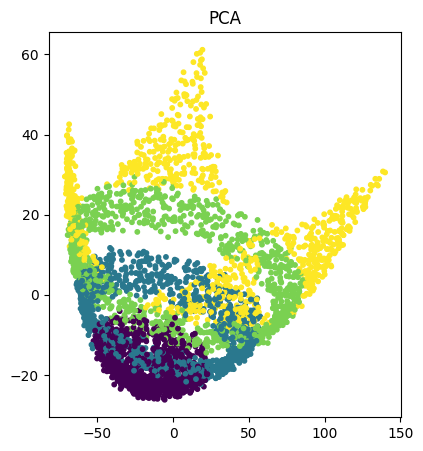

In [51]:
# PCA
fig = plt.figure(figsize=(10, 5))

pca = PCA(n_components=2)
pca.fit(data)
data_pca = pca.transform(data)

ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_pca[:, 0], data_pca[:, 1], c=colors, s=10)
ax.set_title('PCA')


In [85]:
n_neighbors = 12
n_components = 2
params = {
    "n_neighbors": 12,
    "n_components": 2,
    "eigen_solver": "auto",
    "random_state": 0
}


Text(0.5, 1.0, 'LLE LTSA')

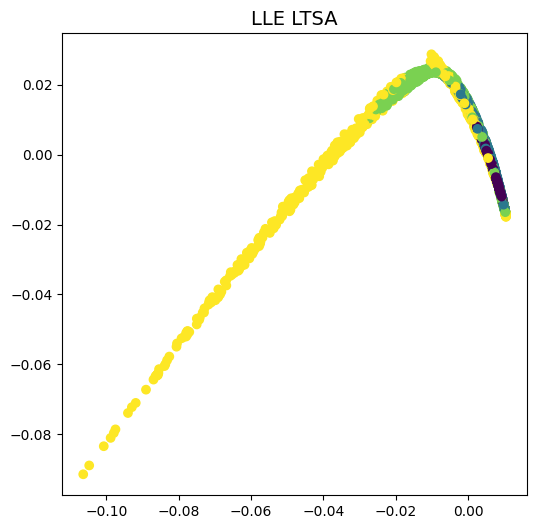

In [86]:
# LLE LTSA
fig = plt.figure(figsize=(6,6))

model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=colors)
ax.set_title('LLE LTSA', size=14)


Text(0.5, 1.0, 'MDS')

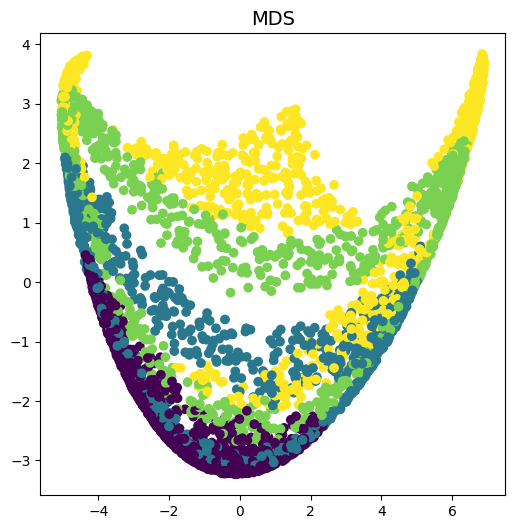

In [74]:
# MDS
fig = plt.figure(figsize=(6,6))

model = MDS(n_components=n_components)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=colors)
ax.set_title('MDS', size=14)


/home/mier/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP')

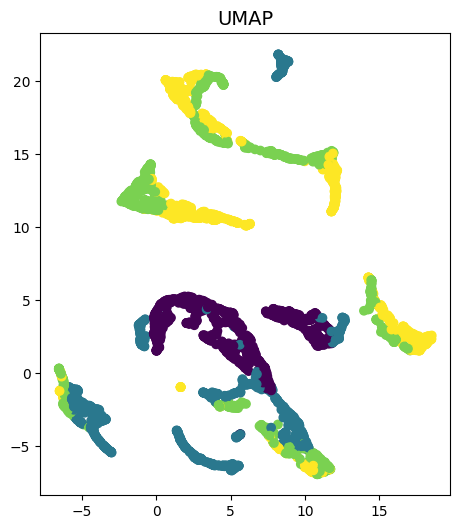

In [59]:
# UMAP
pumap = UMAP(n_components=n_components, init="random", random_state=0)
sr_umap = pumap.fit_transform(points)

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(sr_umap[:, 0], sr_umap[:, 1], c=colors)
ax.set_title('UMAP', size=14)


## Parte opcional 1
Aplica los siguientes métodos:
1. Sammon
2. Isomap
3. t-SNE

Comenta si alguno de estos métodos mejora a los cuatro probados anteriormente.

TolFun exceeded: Optimisation terminated


Text(0.5, 1.0, 'Sammon')

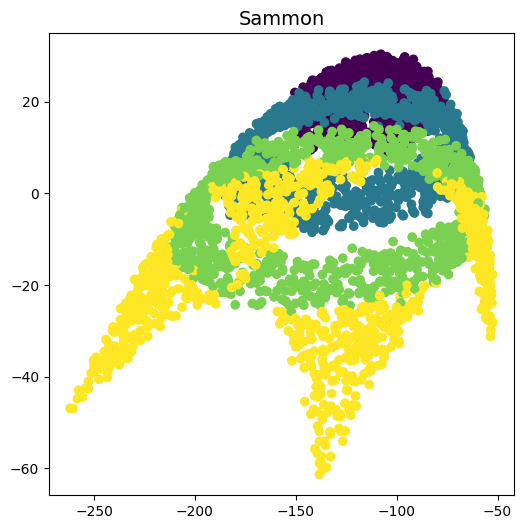

In [60]:
# Sammon
fig = plt.figure(figsize=(6,6))

(sp,index) = np.unique(points,axis=0,return_index=True)
(y,E) = sammon(sp, 2)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y[:, 0], y[:, 1], c=color[index])
ax.set_title('Sammon', size=14)


Text(0.5, 1.0, 'Isomap')

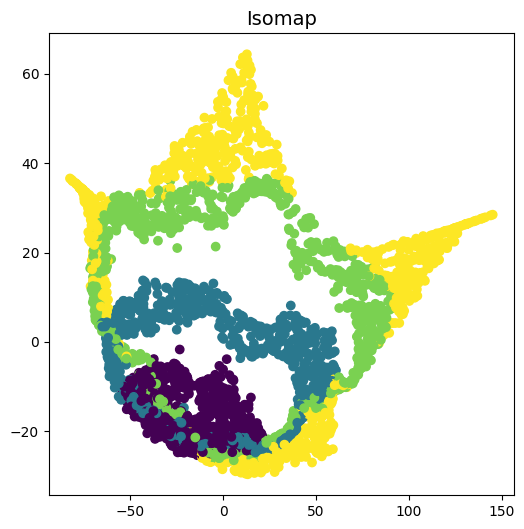

In [61]:
# Isomap
fig = plt.figure(figsize=(6,6))

model = Isomap(n_neighbors=n_neighbors, n_components=n_components)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=colors)
ax.set_title('Isomap', size=14)


Text(0.5, 1.0, 't-SNE')

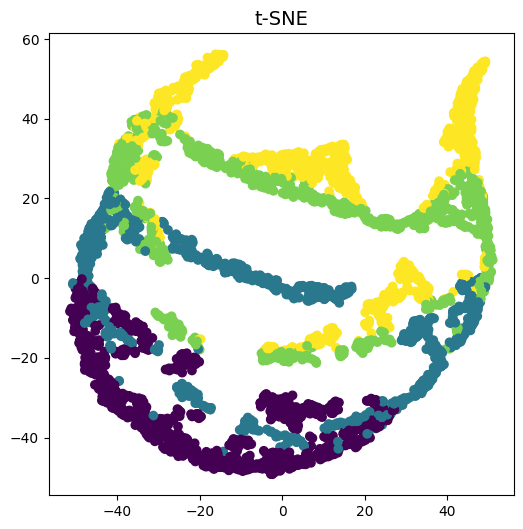

In [62]:
# t-SNE
fig = plt.figure(figsize=(6,6))

sr_tsne = manifold.TSNE(n_components=n_components, perplexity=40, random_state=0).fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=colors)
ax.set_title('t-SNE', size=14)


## Parte opcional 2
Aplica el método Kernel PCA con los kernels sigmoide y rbf (ajusta los parámetros que necesites) y discute los resultados.

Text(0.5, 1.0, 'Kernel PCA con rbf')

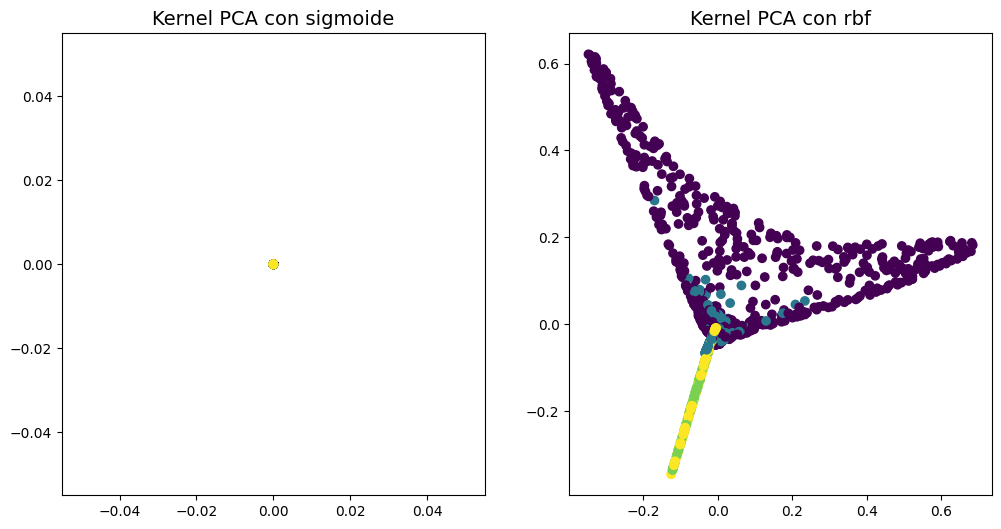

In [77]:
# Kernel PCA con sigmoide y rbf
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)

model = KernelPCA(n_components=n_components, kernel="sigmoid", gamma=0.05)
X = model.fit_transform(points)
ax = axes[0]
ax.scatter(X[:, 0], X[:, 1], c=colors)
ax.set_title('Kernel PCA con sigmoide', size=14)

model = KernelPCA(n_components=n_components, kernel="rbf")
X = model.fit_transform(points)
ax = axes[1]
ax.scatter(X[:, 0], X[:, 1], c=colors)
ax.set_title('Kernel PCA con rbf', size=14)
